# Imports

In [1]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import pandas

from molgroups.support import molstat
from molgroups.infotheory import entropy
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

print(os.getcwd())

# always use the same testdata
shutil.copyfile('./bu/H-D_DMPC_D2O_35C_FQ.ABS', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/H-D_DMPC_35D2O_35C_FQ.ABS', os.getcwd()+'/sim1.dat')
shutil.copyfile('./bu/H-D_DMPC_H2O_35C_FQ.ABS', os.getcwd()+'/sim2.dat')

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_d54DMPC_ThreeContrasts


'/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_d54DMPC_ThreeContrasts/sim2.dat'

# Variables for example fit and optimization

In [2]:
# Run Optimization or only example fit and data simulation
RunOptimization=True

store = "T"
setupdir = os.getcwd()
runfile = "sansves"
fitsource = "SASView"

# remove store directory if it already exists, since we do not want to reload here
if os.path.isdir(os.path.join(setupdir, store)):
    shutil.rmtree(os.path.join(setupdir, store))

burn=2000
steps=200


# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%write_and_run sansves.py
from bumps.names import *
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids

import numpy

# constants
dimension = 100
stepsize = 1.
z = numpy.linspace(0, 99, 100, endpoint=True)

def bilayer(z, bulknsld, l_lipid1, l_lipid2, sigma=3.0, vf_bilayer=1.0):
    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, startz=20., l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)

    # print(z)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.bilayers = [blm]
    problem.dimension = dimension
    problem.stepsize = stepsize
    problem.moldat = blm.fnWritePar2Dict({}, 'bilayer', np.arange(dimension) * stepsize)

    # Return nSLD profile in Refl1D units
    return nsld*1e6

def Dummy(x, l_lipid=1):
    #################################################
    # bilayer update
    # have to figure out how to do a dynamic update
    # that's the code
    sldarr0 = bilayer(z, float(model0.sld_solvent.value), l_lipid, l_lipid)
    sldarr1 = bilayer(z, float(model1.sld_solvent.value), l_lipid, l_lipid)
    sldarr2 = bilayer(z, float(model2.sld_solvent.value), l_lipid, l_lipid)
    for i in range(pars0['n']):
        getattr(model0, 'sld'+str(i+1)).value = sldarr0[i]
        getattr(model1, 'sld'+str(i+1)).value = sldarr1[i]
        getattr(model2, 'sld'+str(i+1)).value = sldarr2[i]
        getattr(model0, 'thickness'+str(i+1)).value = 1.
        getattr(model1, 'thickness'+str(i+1)).value = 1.
        getattr(model2, 'thickness'+str(i+1)).value = 1.

    result = numpy.array([1., 2., 3.]) # + 0 * l_lipid * x
    return result

### Define bilayer object
myristoyl = cmp.Component(name='myristoyl', formula='C13 H27', cell_volume=770./2.0, length=11.0)
dmyristoyl = cmp.Component(name='myristoyl', formula='C13 D27', cell_volume=770./2.0, length=11.0)
DMPC = cmp.Lipid(name='DMPC', headgroup=lipids.PC, tails=2 * [myristoyl], methyls=[cmp.methyl])
dDMPC = cmp.Lipid(name='dDMPC', headgroup=lipids.PC, tails=2 * [dmyristoyl], methyls=[cmp.Dmethyl])
blm = mol.BLM(lipids=[DMPC, dDMPC], lipid_nf=[0.1, 0.9])

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
data1 = load_data('sim1.dat')
data2 = load_data('sim2.dat')

qmin = 0.02
qmax = 0.35
setattr(data0, 'qmin', qmin)
setattr(data0, 'qmax', qmax)
setattr(data1, 'qmin', qmin)
setattr(data1, 'qmax', qmax)
setattr(data2, 'qmin', qmin)
setattr(data2, 'qmax', qmax)

# DEFINE THE MODEL
# copied and initialized the custom model with up to 100 sld and thickness parameters in sasmodels/models
# a second hard-coded limit in sasmodels/modelinfo.py line 594 was manually increased from 20 to 120.
kernel = load_model('my_core_multi_shell@hardsphere')

pars0 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=2.4, radius=500.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)
pars1 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)
pars2 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=500.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)

model0 = Model(kernel, **pars0)
model1 = Model(kernel, **pars1)
model2 = Model(kernel, **pars2)

# Bilayer specific-parameters are passed into a dummy function
xfoo = numpy.array([1., 2., 3.])
yfoo = numpy.array([1., 2., 3.])
dyfoo = numpy.array([0.01, 0.01, 0.01])
M0 = Curve(Dummy, xfoo, yfoo, dyfoo, l_lipid=2)
M0.l_lipid.range(8, 12)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 0.2)
background1 = Parameter(name='background1', value=0.4).range(0.01, 2.0)
background2 = Parameter(name='background2', value=0.4).range(0.01, 2.0)
sld_solvent0 = sld_core0 = Parameter(name='sld_solvent0', value=2.0).range(5.0, 6.4)
sld_solvent1 = sld_core1 = Parameter(name='sld_solvent1', value=2.0).range(1.0, 3.)
sld_solvent2 = sld_core2 = Parameter(name='sld_solvent2', value=2.0).range(-0.56, 2.0)
scale0 = Parameter(name='scale0', value=0.1).range(0.01, 20.0)
scale1 = Parameter(name='scale1', value=0.1).range(0.01, 20.0)
scale2 = Parameter(name='scale2', value=0.1).range(0.01, 40.0)
vf0 = Parameter(name='vf0', value=0.1).range(0.01, 1.0)
vf1 = Parameter(name='vf1', value=0.1).range(0.01, 1.0)
vf2 = Parameter(name='vf2', value=0.1).range(0.01, 1.0)

model0.scale = scale0
model0.background = background0
model0.sld_solvent = sld_solvent0
model0.sld_core = sld_core0
#model0.radius.range(40., 1200.)
model0.radius_pd.range(0.05, 0.5)
model0.radius_effective = model0.radius + 50.
model0.volfraction = vf0

model1.scale = scale1
model1.background = background1
model1.sld_solvent = sld_solvent1
model1.sld_core = sld_core1
#model1.radius = model0.radius
model1.radius_pd=model0.radius_pd
model1.radius_effective = model0.radius
model1.volfraction = vf1

model2.scale = scale2
model2.background = background2
model2.sld_solvent = sld_solvent2
model2.sld_core = sld_core2
#model2.radius = model0.radius
model2.radius_pd=model0.radius_pd
model2.radius_effective = model0.radius
model2.volfraction = vf2

M1 = Experiment(data=data0, model=model0)
M2 = Experiment(data=data1, model=model1)
M3 = Experiment(data=data2, model=model2)

problem = MultiFitProblem([M0, M1, M2, M3])

2. Run Example Fit

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/SANS/LUV_d54DMPC_ThreeContrasts/T/sansves.py
No state to reload.


# steps: 200, # draws: 28000
step 1 cost 8685.148(47)
                                 l_lipid |.........          8 in (8,12)
                             background0 .........|        0.2 in (0.01,0.2)
                               radius_pd .....|....        0.3 in (0.05,0.5)
                                  scale0 |.........        0.1 in (0.01,20)
                            sld_solvent0 |.........          5 in (5,6.4)
                                     vf0 |.........        0.1 in (0.01,1)
                             background1 .|........        0.4 in (0.01,2)
                                  scale1 |.........        0.1 in (0.01,20)
                            sld_solvent1 ....|.....          2 in (1,3)
                                     vf1 |.........        0.1 in (0.01,1)
                             background2 .|........        0.4 in (0.01,2)
                                  scale2 |.........        0.1 in (0.01,40)
                            sld_solvent2 ....

Traceback (most recent call last):
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 438, in wrapper
    return func(*args, **kw)
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/sasmodels/data.py", line 501, in _plot_result1D
    plt.plot(theory_x, theory_scale*mtheory, '-')
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/pyplot.py", line 2740, in plot
    return gca().plot(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 1662, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/Users/frank/opt/anaconda3/envs/Python38/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y mu

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1              l_lipid   9.20(99)   8.924  11.062 [   8.22   10.24] [   8.01   11.38]
 2          background0 0.0617(29)  0.0621  0.0643 [  0.059   0.064] [  0.055   0.066]
 3            radius_pd   0.32(12)   0.364   0.277 [   0.18    0.46] [   0.09    0.49]
 4               scale0    5.2(48)    3.47    0.97 [    0.9    11.2] [    0.3    16.1]
 5         sld_solvent0   5.98(19)   5.948   6.300 [   5.79    6.17] [   5.67    6.37]
 6                  vf0   0.26(23)   0.155   0.207 [   0.07    0.51] [   0.03    0.77]
 7          background1 0.6679(69)  0.6673  0.6763 [  0.661   0.675] [  0.657   0.682]
 8               scale1    3.8(42)    1.87    1.16 [    0.4     7.8] [    0.1    14.6]
 9         sld_solvent1   2.07(62)   2.229   1.215 [   1.30    2.76] [   1.04    2.98]
10                  vf1   0.24(26)   0.125   0.074 [   0.03    0.64] [   0.01    0.83]
11          background2  1.071(14)  1.0694 

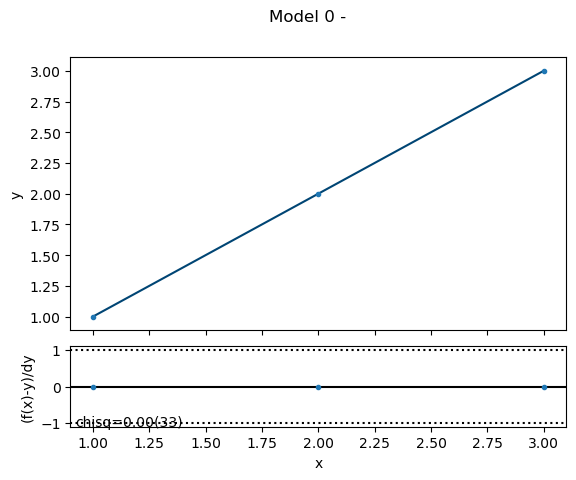

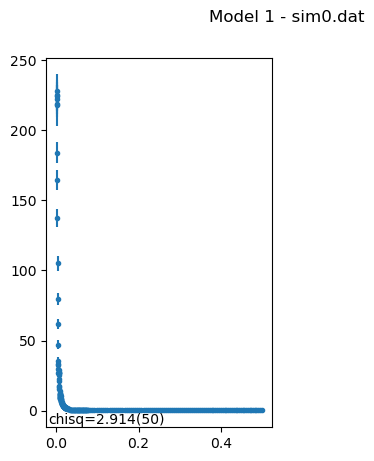

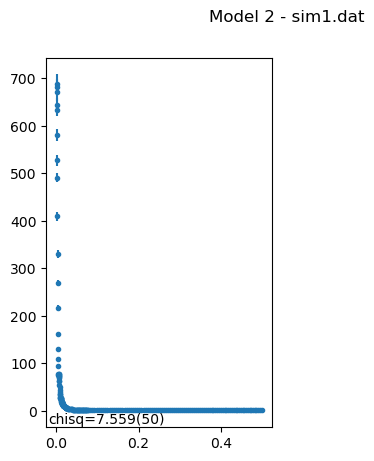

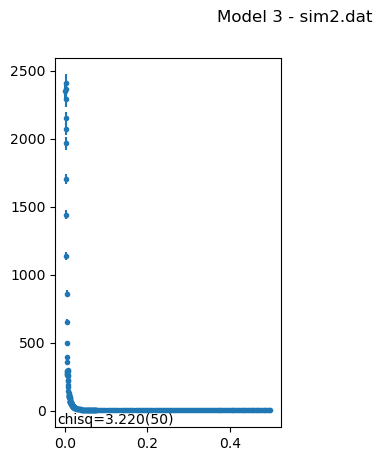

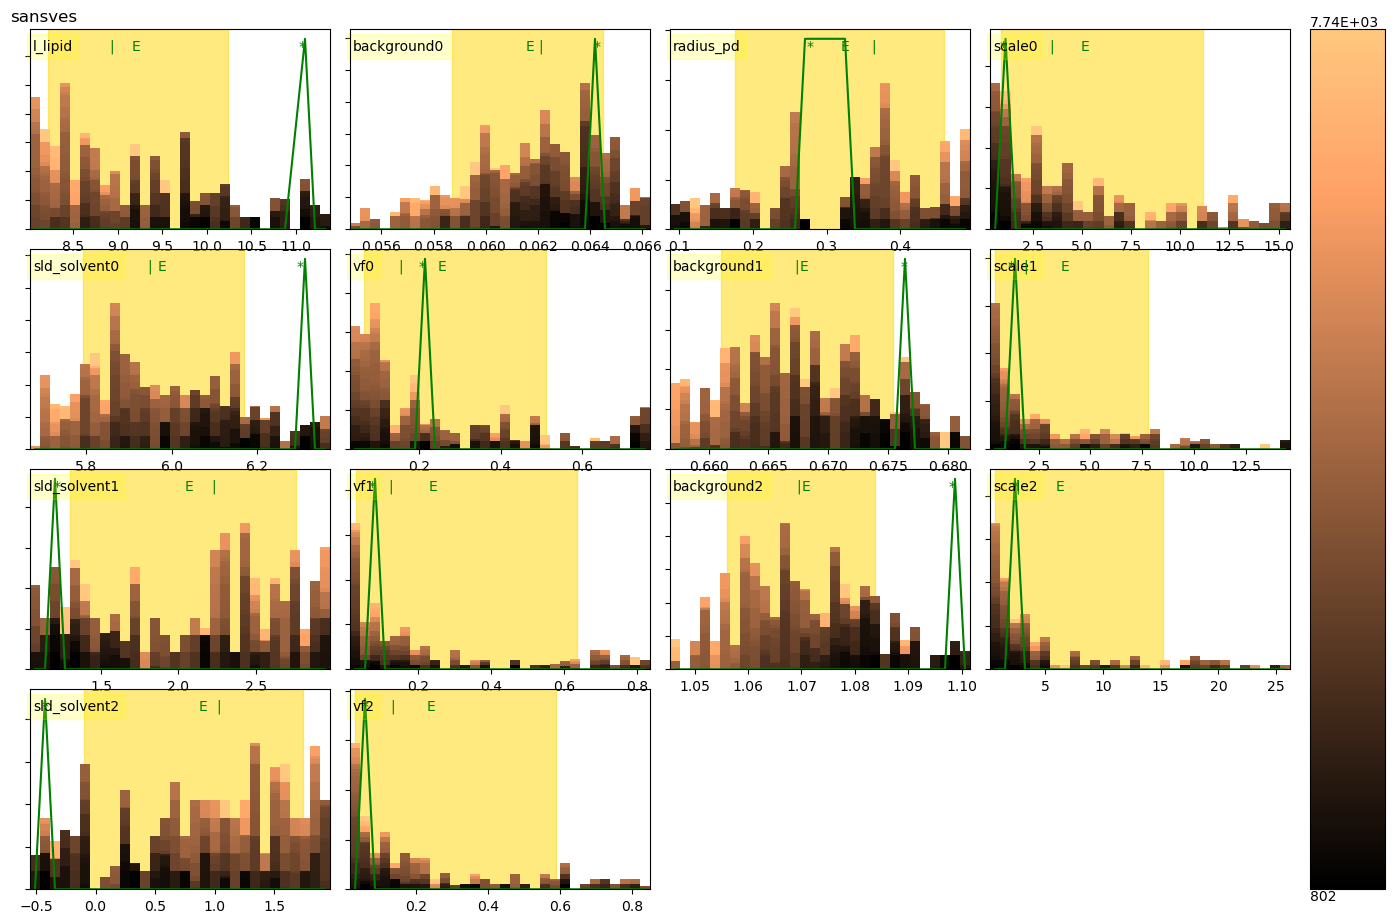

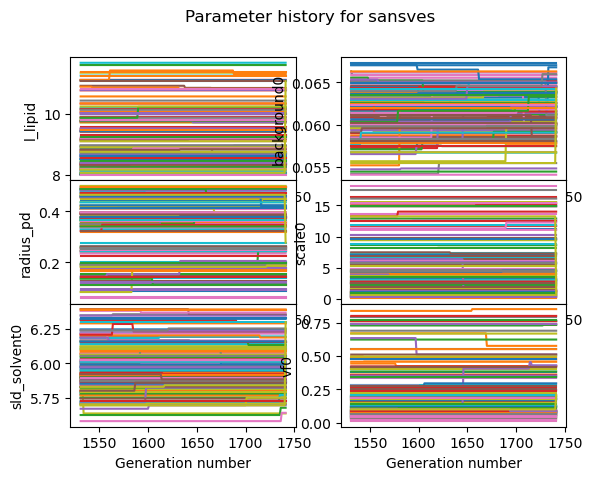

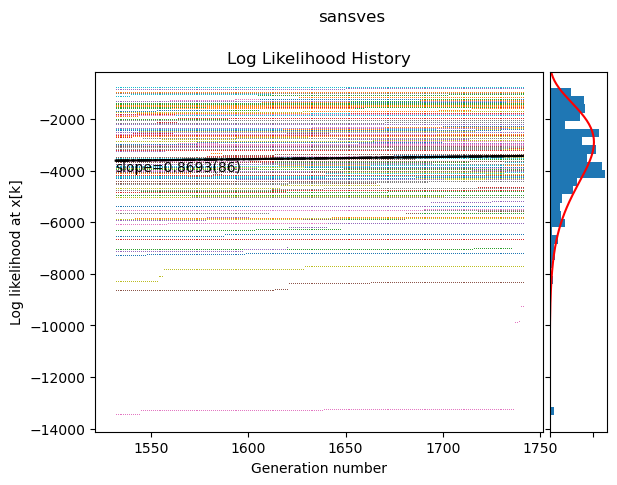

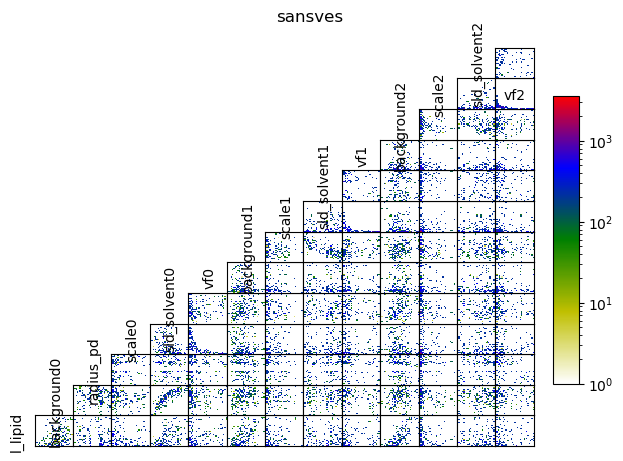

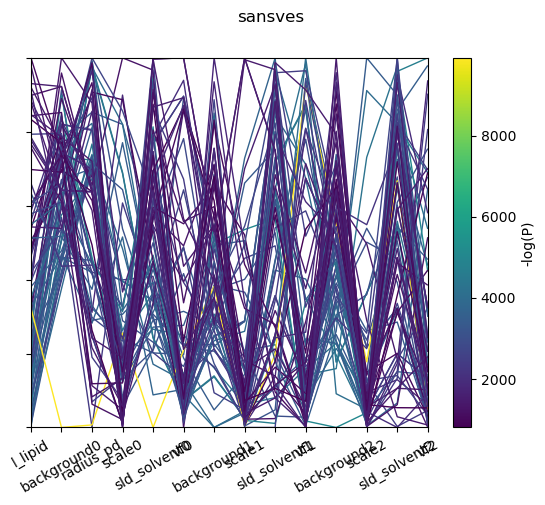

In [5]:
fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

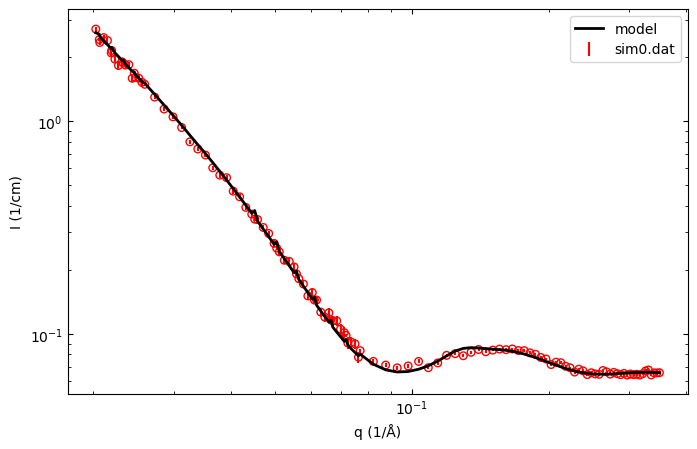

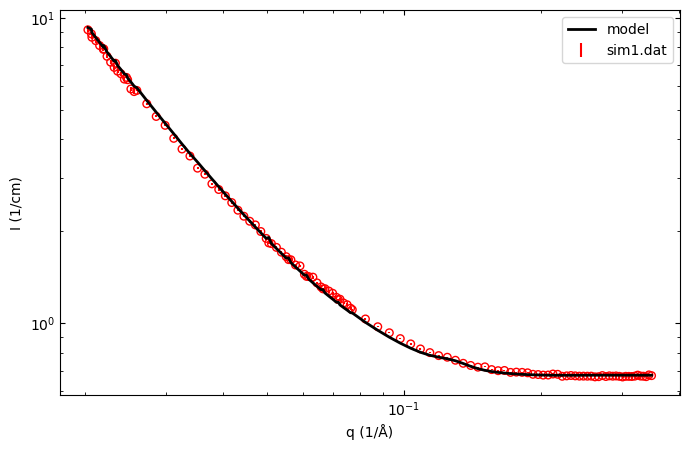

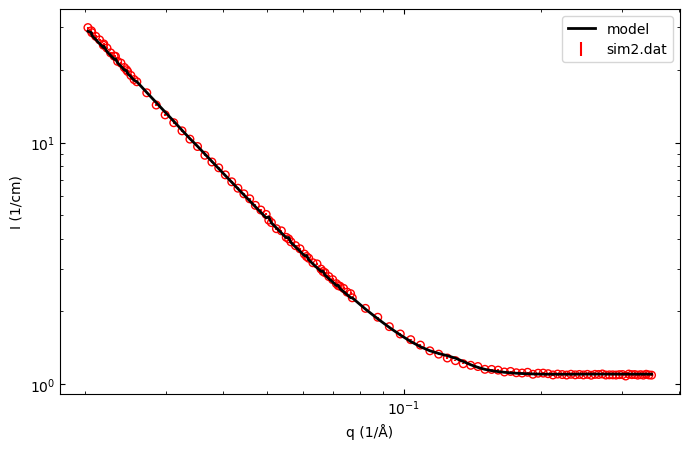

In [16]:
from bumps.dream.state import load_state
import pandas as pd
import matplotlib.pyplot as plt
import bumps.curve

res_state = load_state(os.getcwd() + "/" + store + "/" + runfile)
res_state.mark_outliers()
p = res_state.best()[0]
problem.setp(p)

pd = [None, data0.x[(data0.x >= qmin) & (data0.x <= qmax)], data1.x[(data1.x >= qmin) & (data1.x <= qmax)], data2.x[(data2.x >= qmin) & (data2.x <= qmax)]]

i=0
for M in problem.models:
    M.chisq()
    theo = M.fitness.theory()
    if not isinstance(M.fitness, bumps.curve.Curve):
        fig, ax = plt.subplots()
        ax.errorbar(pd[i], M.fitness.Iq, yerr=M.fitness.dIq, label=M.fitness.name, ls='none', color='r')
        ax.scatter(pd[i], M.fitness.Iq, s=30, marker='o', facecolors='none', edgecolors='r')
        ax.plot(pd[i], theo, label="model", color='black', linewidth=2)
        ax.legend(loc="upper right")
        plt.xlabel("q (1/Å)")
        plt.ylabel("I (1/cm)")
        ax.minorticks_on()
        ax.tick_params(which="both", direction="in", labelsize=10)
        ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax.set_yscale('log')
        ax.set_xscale('log')
        #plt.xlim(0, 100)
        #plt.ylim(1e-2, 1e2)
        #plt.xticks(numpy.arange(-35, 36, 5.0))
        #plt.grid(True, which='Both')
        fig.patch.set_facecolor('white')
        ax.figure.set_size_inches(8, 5)
        plt.savefig(store + "/cvo", facecolor="white")
        plt.show()
    i+=1



In [17]:
sparse = 0.05
fitobj.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of current MC simulation ...
Number of iterations: 1406
     l_lipid  [ |-   |    ]  [         8,        12]  [     8.204(0.000),      8.924(0.000),      10.33(0.000)] (-      0.72, +     1.409)
 background0  [   +       ]  [      0.01,       0.2]  [    0.0586(0.000),    0.06215(0.000),    0.06459(0.000)] (-  0.003546, +  0.002442)
   radius_pd  [   |   - | ]  [      0.05,       0.5]  [    0.1695(0.000),     0.3579(0.000),     0.4592(0.000)] (-    0.1884, +    0.1013)
      scale0  [| -   |    ]  [      0.01,        20]  [    0.7585(0.000),      3.414(0.000),      11.09(0.000)] (-     2.655, +     7.675)
sld_solvent0  [      |- | ]  [         5,       6.4]  [     5.792(0.000),      5.951(0.000),      6.195(0.000)] (-    0.1589, +    0.2437)
         vf0  [ |-  |     ]  [      0.01,         1]  [   0.06517(0.000),     0.1696(0.000),     0.5109(0.000)] (-    0.1044, +    0.3413)
 background1  [   +       ]  [      0

Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat. Plot the median bilayer profile

In [18]:
fitobj.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
Molecular group bilayer.substrate does not exist.
  siox ...
Molecular group bilayer.siox does not exist.
  tether ...
Molecular group bilayer.bME does not exist.
Molecular group bilayer.tetherg does not exist.
Molecular group bilayer.tether does not exist.
Molecular group bilayer.tether_bme does not exist.
Molecular group bilayer.tether_free does not exist.
Molecular group bilayer.tether_hg does not exist.
  innerhg ...
  innerhc ...
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
  outerhc ...
  outerhg ...
  protein ...
Molecular group protein does not exist.
Applying corrections ...

Calculating statistics ...

Saving data to bilayerplotdata.dat ...



In [19]:
fitobj.fnCalculateMolgroupProperty(fConfidence=-1)

Did not find any fractional envelopes ...


/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/molgroups/support/molstat.py:484: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(interval, ignore_index=True)
/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/molgroups/support/molstat.py:484: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(interval, ignore_index=True)
/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/molgroups/support/molstat.py:484: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(interval, ignore_index=True)
/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/progr

WaterFracHeadgroup1  [    0.4987,     0.5513,     0.5782] (-   0.05263, +   0.02689)
WaterFracHeadgroup2  [    0.4515,     0.5064,     0.5357] (-   0.05493, +   0.02932)
WaterFracHydrocarbon  [   0.04303,    0.05746,    0.06855] (-   0.01443, +   0.01109)
WaterFracLipid1  [   0.05092,    0.06513,    0.07751] (-   0.01421, +   0.01237)
WaterFracLipid2  [   0.03573,    0.04851,    0.06039] (-   0.01278, +   0.01188)
WaterFracSubMembrane  [    0.9793,     0.9821,     0.9835] (-  0.002824, +  0.001443)
bilayer.defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hc_INT  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hg_INT  [         0,          0,          0] (

,element,lower_conf,median,upper_conf
0,WaterFracHeadgroup1,0.498719,0.551344,0.578233
1,WaterFracHeadgroup2,0.451475,0.506402,0.535720
2,WaterFracHydrocarbon,0.043029,0.057462,0.068549
3,WaterFracLipid1,0.050924,0.065132,0.077507
4,WaterFracLipid2,0.035726,0.048508,0.060390
...,...,...,...,...
85,bilayer.normarea_COM,49.500000,49.500000,49.500000
86,bilayer.normarea_INT,100.000000,100.000000,100.000000
87,fAreaPerLipid2,64.953524,75.210091,81.810779
88,fTotalLipid1Length,9.411963,10.237988,11.854630


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(store + "/bilayerplotdata.dat", sep="\s", engine="python")

zax = bilayer_plot_data["zaxis"]

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
#ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
#ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
#ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(0, 100)
#plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()